# Integrating lung datasets using EmbedMNN model

In this example, we will use *transmorph* to integrate lung datasets from three patients, gathered in [1]. These datasets contain in total more than 60k cells, which are all associated with a compartment annotation: *immune*, *stromal*, *endothelial* and *epithelial*. As cells show high transcriptomic differences between these compartments, we consider the integration of these datasets to be an "easy" task, compared to cases with many more, and more subtle cell types. We are interested in identifying subclusters in these compartments to identify cell subtypes.

We use one of our built-in models, **EmbedMNN**, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2] and a low-dimensional space embedding using UMAP [3] or MDE [4]. This low dimensional space can subsequently be used to carry out tasks such as clustering.

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Lung databank contains three datasets in the AnnData format, each expressed in its 10,000 most variable genes space. Cells are annotated by the .obs key "class". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [1]:
from transmorph.datasets import load_travaglini_10x

# Format: {patient_label -> AnnData}
datasets = load_travaglini_10x()

# We convert it to List[AnnData] as we do not 
# care about label here
datasets = list(datasets.values())
datasets

databank_api > Loading bank travaglini_10x.


[AnnData object with n_obs × n_vars = 27125 × 10000
     obs: 'class',
 AnnData object with n_obs × n_vars = 28793 × 10000
     obs: 'class',
 AnnData object with n_obs × n_vars = 9744 × 10000
     obs: 'class']

In [2]:
# We take a look at existing classes
set(datasets[0].obs["class"])

{'endothelial', 'epithelial', 'immune', 'stromal'}

### Plotting initial datasets using scatter_plot

The scatter_plot method can be used to display a low dimensional representation of a set of datasets. It will automatically use a *transmorph* integrated representation if present in all AnnData objects. If this integrated representation is missing, it will try to compute a UMAP of .X matrices. Computing this UMAP representation can take some time for large datasets, but it can then be cached to avoid recomputing every time.

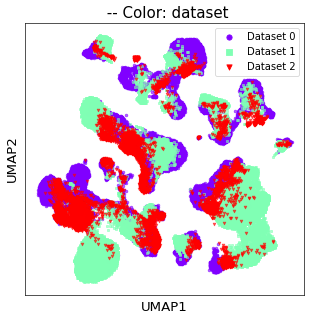

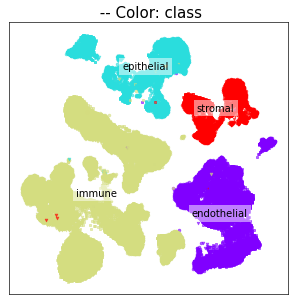

In [3]:
from transmorph.utils.plotting import scatter_plot

# use_cache=True allows to avoid recomputing a UMAP representation for each plot
scatter_plot(datasets, use_cache=True, dpi=60)
scatter_plot(datasets, color_by="class", use_cache=True, plot_cluster_names=True, show_legend=False, dpi=60)

We can see here why we claim this is an "easy" databank to integrate. Differences between compartments are so important that compartments are already clustered in initial gene space. Though, we observe clear patient-dependent subclusters in these compartment clusters, which can cause issue when trying to identify biologically-relevant subpopulations.

### Dataset integration using EmbedMNN

**EmbedMNN** combines a mutual nearest neighbors step and a low-dimensional embedding, here using UMAP. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects. It will add a .obsm["transmorph"] entry, corresponding to the integrated view computed.
**This model starts by embedding all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [ ]:
from transmorph.models import EmbedMNN

# Using these two parameters, we can tune the balance
# between matching edges and knn edges.
model = EmbedMNN(mnn_n_neighbors=30, inner_n_neighbors=5) 
model.transform(datasets)

MODEL > Transmorph model is initializing.
MODEL > Ready to start the integration of 3 datasets, 65662 total samples.
MODEL > Running layer LAYER_INPUT#45.
MODEL > Running layer LAYER_TRANSFORMATION#46.
MODEL > Running layer LAYER_MATCHING#47.
LAYER_MATCHING#47 > Calling matching MATCHING_MNN.
MODEL > Running layer LAYER_MERGING#48.
LAYER_MERGING#48 > Running merging MERGING_GRAPH_EMBEDDING...


In [ ]:
scatter_plot(datasets, dpi=60)
scatter_plot(datasets, color_by="class", show_legend=False, plot_cluster_names=True, dpi=60)

As we can see, **EmbedMNN** has improved separation between compartment-based clusters, and emphasized a better resolved, sub-clustered structure. We have now to assess quantitively that datasets are better merged, and we can doing so using Local Inverse Simpson Index (LISI).

### Comparing dataset homogeneity using LISI

Local Inverse Simpson Index (LISI) is a statistic introduced in the integration algorithm Harmony [5] that measures the source heterogenity of a sample neighborhood in a joint embedding. The higher, the more diverse datasets are in a point's neighborhood, suggesting better dataset integration. *transmorph* contains its implementation of LISI, and we can use it to assess integration quality.

In [16]:
import numpy as np

from transmorph.stats.lisi import compute_lisi

In [7]:
Xs_before = np.concatenate([adata.obsm['tr_plot_representation'] for adata in datasets], axis=0)
Xs_after = np.concatenate([adata.obsm['transmorph'] for adata in datasets], axis=0)
labels = np.array(sum([[i]*adata.n_obs for i, adata in enumerate(datasets)], []))

lisi_before = compute_lisi(Xs_before, labels)
lisi_after = compute_lisi(Xs_after, labels)
print(
    f"LISI before - min: {lisi_before.min()}, max: {lisi_before.max()}, "
    f"mean: {lisi_before.mean()}, median: {np.median(lisi_before)}"
)
print(
    f"LISI after - min: {lisi_after.min()}, max: {lisi_after.max()}, "
    f"mean: {lisi_after.mean()}, median: {np.median(lisi_after)}"
)

LISI before - min: 0.9999995231630692, max: 2.999509146668781, mean: 1.2892556726143425, median: 1.0458645087521274
LISI after - min: 0.9999995231630692, max: 2.9999765755575063, mean: 1.8084716981249134, median: 1.7807816940179513


As we can see, performing the integration step using **EmbedMNN** greatly increased mean and median LISI score, from an average of 1.3 datasets per sample neighborhood to around 1.8 datasets per sample neighborhood.

### Performing clustering in embedding space

A common task after embedding datasets in a common space is to perform clustering. *transmorph* allows to easily do so using the *cluster_anndatas* function, which leverages Leiden [6] algorithm to provide a reasonable community detection. AnnDatas objects that have been processed by *transmorph* can be directly passed to the function, and "resolution" parameter can be tuned to reach a satisfying cluster attribution.

In [35]:
from transmorph.utils.graph import cluster_anndatas

# The lower the resolution, the less clusters
cluster_anndatas(datasets, n_neighbors=20, resolution=0.0001) 

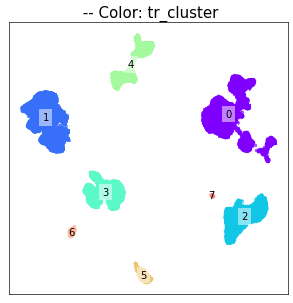

In [36]:
scatter_plot(datasets, show_legend=False, plot_cluster_names=True, color_by="tr_cluster", dpi=60)

AnnData objects can then be saved with their new cluster annotations and joint embedding. Cell type detection can subsequently be carried out on each of these clusters using third-party tools such as *sc-type* in R [6] in order to annotate these clusters with cell types.

## References

[1] Travaglini, Kyle J., et al. *A molecular cell atlas of the human lung from single-cell RNA sequencing.*, **Nature** 587.7835 (2020): 619-625.

[2] Haghverdi, Laleh, et al. *Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.* **Nature biotechnology** 36.5 (2018): 421-427.

[3] Becht, Etienne, et al. *Dimensionality reduction for visualizing single-cell data using UMAP.* **Nature biotechnology** 37.1 (2019): 38-44.

[4] Agrawal, Akshay, Alnur Ali, and Stephen Boyd. *Minimum-distortion embedding.* **arXiv preprint** arXiv:2103.02559 (2021).

[5] Korsunsky, Ilya, et al. *Fast, sensitive and accurate integration of single-cell data with Harmony.* **Nature methods** 16.12 (2019): 1289-1296.

[6] Ianevski, Aleksandr, Anil K. Giri, and Tero Aittokallio. *Fully-automated and ultra-fast cell-type identification using specific marker combinations from single-cell transcriptomic data.* **Nature communications** 13.1 (2022): 1-10.